In [1]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score

import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data.explorer import UniformRandomWalk
from stellargraph import StellarGraph
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

In [2]:
data = datasets.Cora()
display(HTML(data.description))
g, node_sub = data.load(largest_connected_component_only=True)

In [3]:
print(g.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)
        Features: none


In [20]:
import time
first = time.localtime(time.time())
print(first)
random_walk = UniformRandomWalk(g) #DeepWalk 
walks = random_walk.run(
nodes=list(g.nodes()), 
    length=50,  #Maximum length of Random Walk 
    n=10) #No. of Random Walks per root node 
print("Number of random walks: {}".format(len(walks)))
last = time.localtime(time.time())
print(last)
#print(last - first)

time.struct_time(tm_year=2021, tm_mon=4, tm_mday=7, tm_hour=19, tm_min=54, tm_sec=49, tm_wday=2, tm_yday=97, tm_isdst=0)
Number of random walks: 24850
time.struct_time(tm_year=2021, tm_mon=4, tm_mday=7, tm_hour=19, tm_min=55, tm_sec=29, tm_wday=2, tm_yday=97, tm_isdst=0)


In [21]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=4)

In [22]:
model.wv["1107010"].shape

(128,)

In [23]:
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_sub[[int(node_id) for node_id in node_ids]]

In [24]:
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

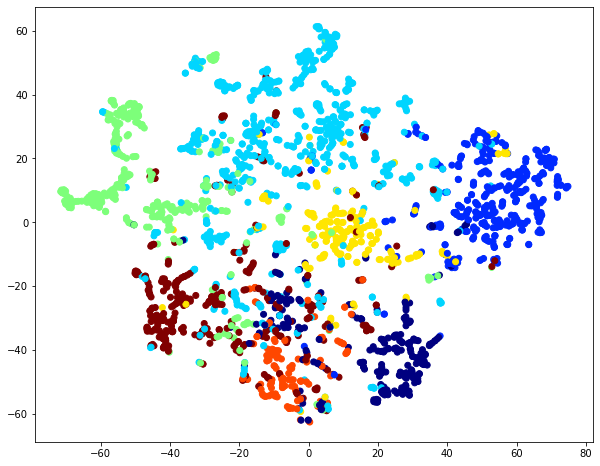

In [25]:

label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet"
)

In [26]:
#X will hold the 128-dimensional input features
X = node_embeddings
# y holds the corresponding target values
y = np.array(node_targets)

In [27]:
#75% training and 25% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)

In [28]:
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (248, 128)
 y_train = (248,)
 X_test = (2237, 128)
 y_test = (2237,)


In [29]:
#Logistic Regression for Classification of Research papers in CORA dataset 
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
#cs for inverse of regularization, cv = kfolds, max_iyer= max iterations of optimization algo
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

In [30]:
y_pred = clf.predict(X_test)

In [31]:
accuracy_score(y_test, y_pred)

0.7572641931157801

In [32]:
f1_score(y_test, y_pred, average='micro') #micro for multilabel classification 

0.7572641931157801

                        precision    recall  f1-score   support

            Case_Based       0.76      0.79      0.78       253
    Genetic_Algorithms       0.87      0.87      0.87       376
       Neural_Networks       0.71      0.81      0.76       653
 Probabilistic_Methods       0.81      0.72      0.76       331
Reinforcement_Learning       0.80      0.66      0.72       201
         Rule_Learning       0.73      0.66      0.69       116
                Theory       0.66      0.62      0.64       307

              accuracy                           0.76      2237
             macro avg       0.76      0.73      0.75      2237
          weighted avg       0.76      0.76      0.76      2237



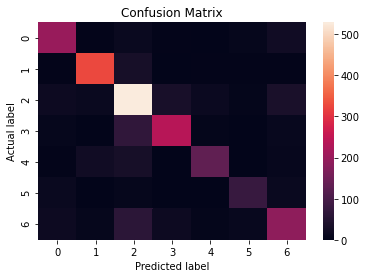

In [33]:
#Confusion Matrix for Classification Report 
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

Mul_cm = metrics.confusion_matrix(y_test, y_pred)
plt.show()
plt.figure()
sns.heatmap(Mul_cm);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix');

report = classification_report(y_test, y_pred)
print(report)
              

In [34]:
print(y_pred[10])
print(y_test[10])

Neural_Networks
Neural_Networks
